# DATA PRE-PROCESSING

In [1]:
import pandas as pd
import numpy as np

# Load the datasets
train_path = "UNSW_NB15_training-set.csv"
test_path = "UNSW_NB15_testing-set.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)


ELIMINATING IRRELEVANT AND REDUNTANT INFORMATION

In [2]:
# Function to eliminate irrelevant and redundant information
def clean_data(df):
    # Step 1: Drop Irrelevant Columns
    irrelevant_cols = ['id', 'srcip', 'dstip', 'stime', 'ltime']  # IDs & timestamps
    df.drop(columns=[col for col in irrelevant_cols if col in df.columns], inplace=True, errors='ignore')

    # Step 2: Remove Duplicate Rows
    df.drop_duplicates(inplace=True)

    return df



In [3]:
# Apply the function to training and testing datasets
df_train = clean_data(df_train)
df_test = clean_data(df_test)

HANDLING MISSING VALUES

In [4]:
# Function to handle missing values
def handle_missing_values(df):
    # Step 1: Replace potential placeholders for missing values ('-', 'NA', 'N/A', etc.)
    df.replace(['-', 'NA', 'N/A', 'unknown', 'null', 'NULL'], pd.NA, inplace=True)
    
    # Step 2: Drop columns with >40% missing data
    missing_percent = (df.isnull().sum() / len(df)) * 100
    cols_to_drop = missing_percent[missing_percent > 40].index
    df.drop(columns=cols_to_drop, inplace=True)
    
    # Step 3: Drop rows with >30% missing data
    df.dropna(thresh=len(df.columns) * 0.7, inplace=True)
    
    # Step 4: Identify numerical and categorical features
    num_cols = df.select_dtypes(include=['number']).columns
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Step 5: Apply Median Imputation for Numerical Features
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            df[col] = df[col].fillna(df[col].median())

    # Step 6: Apply Dynamic Imputation for Categorical Features
    for col in cat_cols:
        if df[col].isnull().sum() > 0:
            if df[col].nunique() < 10:  # Few unique categories → Use Mode
                df[col] = df[col].fillna(df[col].mode()[0])
            else:  # Many unique categories → Use 'Unknown'
                df[col] = df[col].fillna("Unknown")

    return df


Saving the new dataset after handling missing value

In [5]:
# Apply the function to training and testing datasets
df_train_cleaned = handle_missing_values(df_train)
df_test_cleaned = handle_missing_values(df_test)

# Save the cleaned datasets into new files
df_train_cleaned.to_csv("UNSW_NB15_training_cleaned_new.csv", index=False)
df_test_cleaned.to_csv("UNSW_NB15_testing_cleaned_new.csv", index=False)

print("✅ Missing values handled and datasets saved to new files!")

✅ Missing values handled and datasets saved to new files!


Checking how well we handled missing values

In [6]:
# Function to check missing values (including placeholders for missing data)
def check_missing_values(df):
    # Replace potential placeholders for missing values ('-', 'NA', 'N/A', etc.)
    df_replaced = df.replace(['-', 'NA', 'N/A', 'unknown', 'null', 'NULL'], pd.NA)
    
    # Count the total number of missing values in the dataset
    missing_values_count = df_replaced.isnull().sum().sum()  # Total number of missing values
    missing_values_per_column = df_replaced.isnull().sum()   # Missing values per column
    
    return missing_values_count, missing_values_per_column

# Load the original and cleaned datasets
df_train_original = pd.read_csv(train_path)
df_test_original = pd.read_csv(test_path)

df_train_cleaned = pd.read_csv("UNSW_NB15_training_cleaned_new.csv")
df_test_cleaned = pd.read_csv("UNSW_NB15_testing_cleaned_new.csv")

# Check missing values in the original datasets
train_original_missing_count, train_original_missing_per_column = check_missing_values(df_train_original)
test_original_missing_count, test_original_missing_per_column = check_missing_values(df_test_original)

# Check missing values in the cleaned datasets
train_cleaned_missing_count, train_cleaned_missing_per_column = check_missing_values(df_train_cleaned)
test_cleaned_missing_count, test_cleaned_missing_per_column = check_missing_values(df_test_cleaned)

# Print results
print(f"Original training dataset - Total missing values: {train_original_missing_count}")
print(f"Missing values per column in original training dataset:\n{train_original_missing_per_column}")
print(f"\nOriginal testing dataset - Total missing values: {test_original_missing_count}")
print(f"Missing values per column in original testing dataset:\n{test_original_missing_per_column}")

print(f"\nCleaned training dataset - Total missing values: {train_cleaned_missing_count}")
print(f"Missing values per column in cleaned training dataset:\n{train_cleaned_missing_per_column}")
print(f"\nCleaned testing dataset - Total missing values: {test_cleaned_missing_count}")
print(f"Missing values per column in cleaned testing dataset:\n{test_cleaned_missing_per_column}")


Original training dataset - Total missing values: 47153
Missing values per column in original training dataset:
id                       0
dur                      0
proto                    0
service              47153
state                    0
spkts                    0
dpkts                    0
sbytes                   0
dbytes                   0
rate                     0
sttl                     0
dttl                     0
sload                    0
dload                    0
sloss                    0
dloss                    0
sinpkt                   0
dinpkt                   0
sjit                     0
djit                     0
swin                     0
stcpb                    0
dtcpb                    0
dwin                     0
tcprtt                   0
synack                   0
ackdat                   0
smean                    0
dmean                    0
trans_depth              0
response_body_len        0
ct_srv_src               0
ct_state_ttl            

ENCODING CATEGORIAL VARIABLES

In [7]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce  # For Binary Encoding

# Load datasets
train_path = "UNSW_NB15_training_cleaned_new.csv"
test_path = "UNSW_NB15_testing_cleaned_new.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Function to encode categorical variables consistently
def encode_categorical_variables(df_train, df_test, high_cardinality_threshold=15):
    """Encodes categorical variables using One-Hot Encoding for low-cardinality 
       features and Binary Encoding for high-cardinality features.
    """
    # Identify categorical columns
    cat_cols = df_train.select_dtypes(include=['object']).columns.tolist()

    # Separate categorical variables based on cardinality
    high_cardinality_cols = [col for col in cat_cols if df_train[col].nunique() > high_cardinality_threshold]
    low_cardinality_cols = [col for col in cat_cols if df_train[col].nunique() <= high_cardinality_threshold]

    # --- Step 1: One-Hot Encoding (Low-Cardinality Features) ---
    one_hot_encoder = OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
    
    train_one_hot = one_hot_encoder.fit_transform(df_train[low_cardinality_cols])
    test_one_hot = one_hot_encoder.transform(df_test[low_cardinality_cols])

    # Convert to DataFrame
    train_one_hot_df = pd.DataFrame(train_one_hot, columns=one_hot_encoder.get_feature_names_out(low_cardinality_cols), index=df_train.index)
    test_one_hot_df = pd.DataFrame(test_one_hot, columns=one_hot_encoder.get_feature_names_out(low_cardinality_cols), index=df_test.index)

    # --- Step 2: Binary Encoding (High-Cardinality Features) ---
    binary_encoder = ce.BinaryEncoder(cols=high_cardinality_cols)
    
    df_train_binary = binary_encoder.fit_transform(df_train[high_cardinality_cols])
    df_test_binary = binary_encoder.transform(df_test[high_cardinality_cols])

    # --- Step 3: Combine Encoded Data ---
    df_train_encoded = df_train.drop(columns=cat_cols).reset_index(drop=True)
    df_test_encoded = df_test.drop(columns=cat_cols).reset_index(drop=True)

    df_train_encoded = pd.concat([df_train_encoded, train_one_hot_df, df_train_binary], axis=1)
    df_test_encoded = pd.concat([df_test_encoded, test_one_hot_df, df_test_binary], axis=1)

    # --- Step 4: Align Columns in Train & Test ---
    missing_cols = set(df_train_encoded.columns) - set(df_test_encoded.columns)
    for col in missing_cols:
        df_test_encoded[col] = 0  # Add missing columns to test set with 0s

    df_test_encoded = df_test_encoded[df_train_encoded.columns]  # Ensure same column order

    return df_train_encoded, df_test_encoded

# Apply encoding
df_train_encoded, df_test_encoded = encode_categorical_variables(df_train, df_test)

# Save the encoded datasets
df_train_encoded.to_csv("UNSW_NB15_training_cleaned_new.csv", index=False)
df_test_encoded.to_csv("UNSW_NB15_testing_cleaned_new.csv", index=False)

print("✅ Encoding complete! Train and test sets now have consistent features.")


C:\Users\garvm\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


✅ Encoding complete! Train and test sets now have consistent features.


# DECISION TREE MODEL

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer

# Load the preprocessed datasets
train_path = "UNSW_NB15_training_cleaned_new.csv"
test_path = "UNSW_NB15_testing_cleaned_new.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Define target variable (binary classification)
target_column = "label"  # Changed to "label" for binary classification

# Separate features (X) and target (y)
X_train = df_train.drop(columns=[target_column])
y_train = df_train[target_column]

X_test = df_test.drop(columns=[target_column])
y_test = df_test[target_column]

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Initialize Decision Tree model
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions on validation and test sets
y_val_pred = dt_model.predict(X_val)
y_test_pred = dt_model.predict(X_test)


# EVALUATING AND TESTING THE MODEL

Accuracy: 100.00%


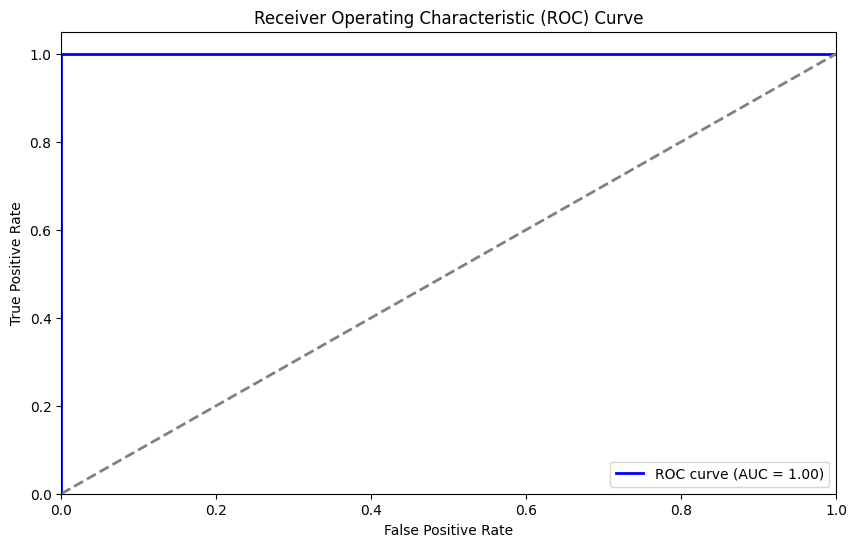

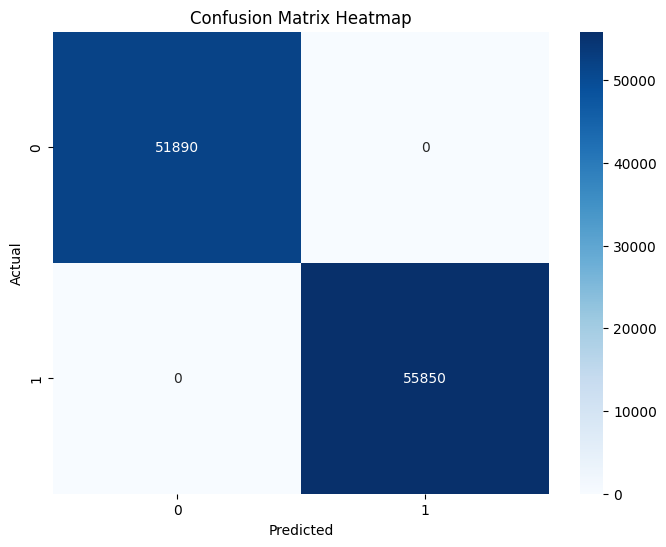


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     51890
           1       1.00      1.00      1.00     55850

    accuracy                           1.00    107740
   macro avg       1.00      1.00      1.00    107740
weighted avg       1.00      1.00      1.00    107740



In [9]:
# 1. Accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# 2. Plot AUC-ROC Curve
# Binarize the labels for multi-class classification (if applicable)
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)
y_val_bin = lb.transform(y_val)

# Get probability predictions for AUC-ROC curve (output of Decision Tree for each class)
y_test_prob = dt_model.predict_proba(X_test)[:, 1]  # Probability for the positive class

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_bin, y_test_prob)
roc_auc = roc_auc_score(y_test_bin, y_test_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 3. Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 4. Precision, Recall, F1 Scores
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
